# Import packages

In [1]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import pandas as pd
import numpy as np
import random
import sc_toolbox
import pertpy 
import rpy2.robjects as robjects
import rpy2.rinterface_lib.callbacks
import anndata2ri
import logging
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter
from rpy2.robjects import pandas2ri
from rpy2.robjects import r
from modules.deg_analysis import *
sc.settings.verbosity = 0
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

# Load dataset

In [2]:
adata = sc.read(
    filename="data/fede_count_clustered.h5ad"
)

# Differential gene expression analysis - Sample level

In [3]:
cell_types = adata.obs["cluster_subclass_name"].cat.categories
adata_pb = aggregate_and_filter(adata, 
                                cell_types[0], 
                                condition_key="Sample_Tag", 
                                cell_identity_key="cluster_subclass_name", 
                                obs_to_keep=['Sample_Tag', 'cluster_subclass_name'])

for i, cell_type in enumerate(cell_types[1:], start=2):
    adata_cell_type = aggregate_and_filter(adata, 
                                           cell_type, 
                                           condition_key="Sample_Tag", 
                                           cell_identity_key="cluster_subclass_name", 
                                           obs_to_keep=['Sample_Tag', 'cluster_subclass_name'])
    adata_pb = adata_pb.concatenate(adata_cell_type)

adata_pb.layers['counts'] = adata_pb.X.copy()

### Pseudo-replicates PCA

In [4]:
sc.pp.normalize_total(adata_pb, target_sum=1e6)
sc.pp.log1p(adata_pb)
sc.pp.pca(adata_pb)

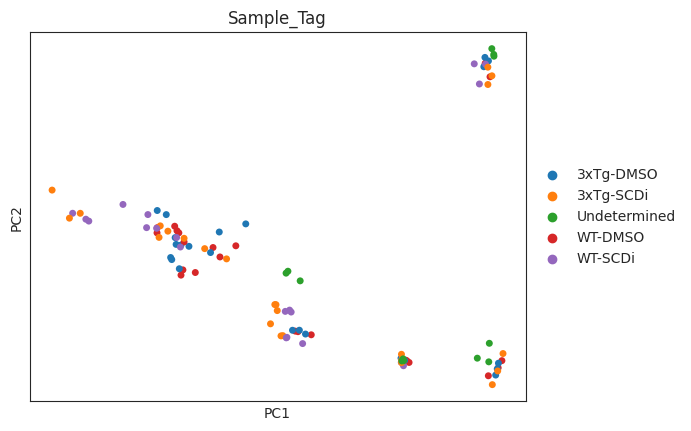

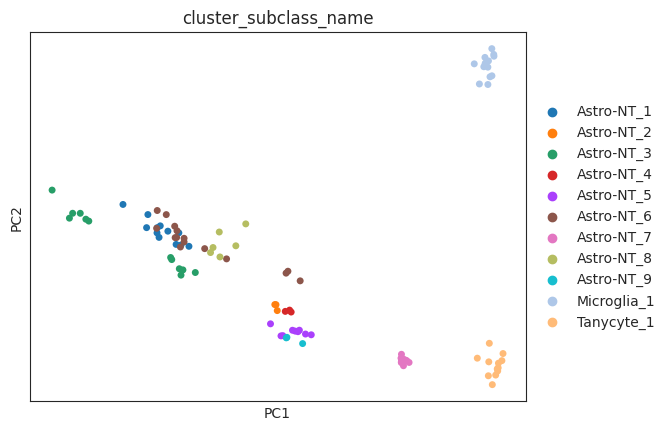

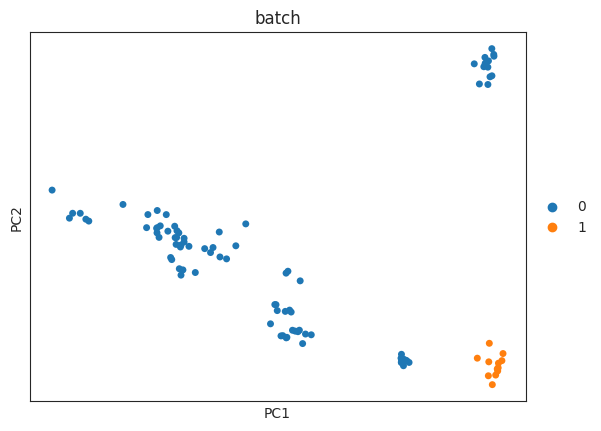

In [5]:
sc.settings.figdir = 'figures/pca_plot_'
color_vars = adata_pb.obs.columns
for var in color_vars:
    sc.pl.pca(adata_pb, color=var, ncols=1, size=100, save=f'pca_plot_{var}.png')

### Create control and condition anndata objects

In [42]:
ctr_name = 'All astro'
cnd_name = 'Astro 9'

In [43]:
adata_pb.X = adata_pb.layers['counts'].copy()
adata_pb.X = adata_pb.X.astype(np.float32)

In [44]:
ctr_sample_tags = list(set(adata.obs['Sample_Tag'].values))
#ctr_sample_tags = ['WT-DMSO']

cnd_sample_tags = list(set(adata.obs['Sample_Tag'].values))
#cnd_sample_tags = ['WT-SCDi']

In [45]:
control_df = adata_pb[
    (adata_pb.obs['Sample_Tag'].isin(ctr_sample_tags)) &
    (adata_pb.obs['cluster_subclass_name'] != 'Astro-NT_9') &
    (adata_pb.obs['cluster_subclass_name'].str.startswith('Astro-NT'))
].to_df()

In [46]:
condition_df = adata_pb[(adata_pb.obs['Sample_Tag'].isin(cnd_sample_tags)) & (adata_pb.obs['cluster_subclass_name'] == 'Astro-NT_9')].to_df()

In [47]:
results_df = deseq2_dea(control_df, condition_df, save_path=None)

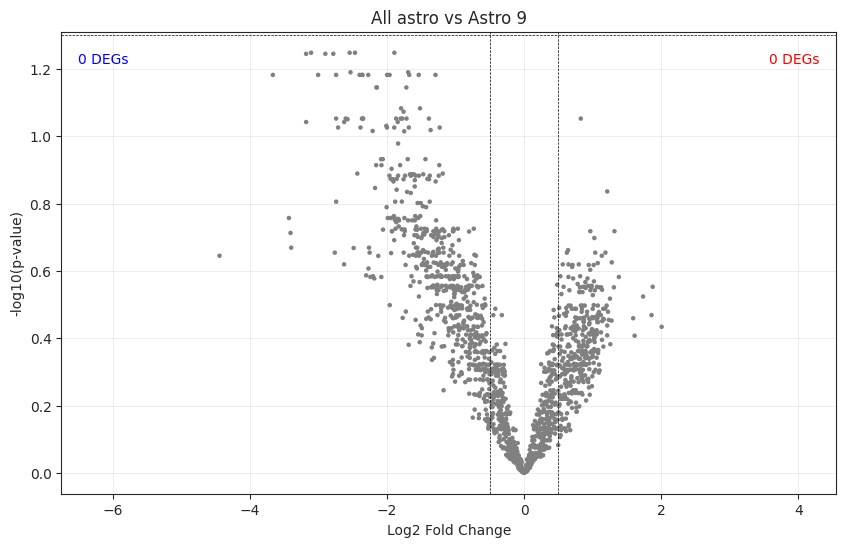

In [48]:
volcano_plot(results_df,
             min_fold_change=0.5,
             max_p_value=0.05,
             fig_title=f'{ctr_name} vs {cnd_name}',
             save_path=f'figures/{ctr_name}_{cnd_name}_volcano_plot.png')

In [49]:
ranked_genes = results_df.sort_values(by='padj')

In [50]:
ranked_genes.head(10)

,names,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
13943,Magi2,76.491094,-2.545005,0.662039,-3.844190,0.000121,0.056421
2416,Atad2b,14.640245,-3.107146,0.799631,-3.885724,0.000102,0.056421
3984,Chd7,12.659942,-1.892318,0.489668,-3.864488,0.000111,0.056421
5382,Dock4,48.373909,-2.467202,0.649202,-3.800364,0.000144,0.056421
19480,Smg6,13.926995,-2.783222,0.755034,-3.686220,0.000228,0.056833
12728,Il1rapl1,50.701487,-3.179790,0.850800,-3.737412,0.000186,0.056833
12228,Hdac8,43.934727,-2.899320,0.792707,-3.657493,0.000255,0.056833
13016,Jmjd1c,20.662458,-1.691306,0.475160,-3.559445,0.000372,0.064500
14410,Mir99ahg,86.305397,-2.532148,0.706515,-3.583999,0.000338,0.064500
8068,Gm12239,14.358828,-3.664847,1.085531,-3.376088,0.000735,0.065665


# Differential gene expression analysis - Cell level

### Create control and condition anndata objects

In [32]:
ctr_name = '_'
cnd_name = '_'

In [197]:
adata.X = adata.layers['counts']
sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.log1p(adata)

In [198]:
ctr_sample_tags = list(set(adata.obs['Sample_Tag'].values))
ctr_sample_tags = ['WT-DMSO']

cnd_sample_tags = list(set(adata.obs['Sample_Tag'].values))
cnd_sample_tags = ['3xTg-DMSO']

In [199]:
control_df = adata[(adata.obs['Sample_Tag'].isin(ctr_sample_tags)) & (adata.obs['class_name'] == '30 Astro-Epen')].to_df()
condition_df = adata[(adata.obs['Sample_Tag'].isin(cnd_sample_tags)) & (adata.obs['class_name'] == '30 Astro-Epen')].to_df()

In [200]:
results_df = mast_dea(adata, control_df, condition_df, save_path=None)

[1] "Shape of exprs_data: 0 x 0"
[1] "Shape of cdata: 0 x 1"
[1] "Shape of fdata: 25244 x 1"


RRuntimeError: Error in checkAssayNames(assays, cData, fData) : 
  `fData` must contain as many columns as `exprsArray`


### Visualization - Volcano plot

In [ ]:
volcano_plot(results_df,
             min_fold_change=0.5,
             max_p_value=0.05,
             fig_title=f'{ctr_name} vs {cnd_name}',
             save_path=f'figures/{ctr_name}_{cnd_name}_volcano_plot.png')

# Gene set and pathway enrichment analysis

In [51]:
UP_genes_name, DOWN_genes_name = get_DEGs(results_df,
                                          max_pval=0.05,
                                          min_fold_change=0.5)

In [52]:
UP_GO = go_enrichment_analysis(UP_genes_name, save_path=None)
DOWN_GO = go_enrichment_analysis(DOWN_genes_name, save_path=None)

Exception: Error sending gene list, try again later

In [ ]:
display_go_enrichment(UP_GO,
                      namespace='BP',
                      fig_title=f'UP BP - {ctr_name} vs {cnd_name}',
                      save_path=f'figures/{ctr_name}_{cnd_name}_display_GO_enrichment_UP_BP')

display_go_enrichment(UP_GO, 
                      namespace='MF',
                      fig_title=f'UP MF - {ctr_name} vs {cnd_name}',
                      save_path=f'figures/{ctr_name}_{cnd_name}_display_GO_enrichment_UP_MF')

display_go_enrichment(UP_GO, 
                      namespace='CC',
                      fig_title=f'UP CC - {ctr_name} vs {cnd_name}',
                      save_path=f'figures/{ctr_name}_{cnd_name}_display_GO_enrichment_UP_CC')

In [ ]:
display_go_enrichment(DOWN_GO, 
                      namespace='BP',
                      fig_title=f'DOWN BP - {ctr_name} vs {cnd_name}',
                      save_path=f'figures/{ctr_name}_{cnd_name}_display_GO_enrichment_DOWN_BP')

display_go_enrichment(DOWN_GO, 
                      namespace='MF',
                      fig_title=f'DOWN MF - {ctr_name} vs {cnd_name}',
                      save_path=f'figures/{ctr_name}_{cnd_name}_display_GO_enrichment_DOWN_MF')

display_go_enrichment(DOWN_GO, 
                      namespace='CC',
                      fig_title=f'DOWN CC - {ctr_name} vs {cnd_name}',
                      save_path=f'figures/{ctr_name}_{cnd_name}_display_GO_enrichment_DOWN_CC')

In [ ]:
UP_KEGG = kegg_enrichment_analysis(UP_genes_name, 
                                   save_path=None)

In [ ]:
DOWN_KEGG = kegg_enrichment_analysis(DOWN_genes_name, 
                                     save_path=None)

In [ ]:
display_kegg_enrichment(UP_KEGG,
                        fig_title=f'UP pathway - {ctr_name} vs {cnd_name}',
                        save_path=f'figures/{ctr_name}_{cnd_name}_display_KEGG_enrichment_UP')

In [ ]:
display_kegg_enrichment(DOWN_KEGG,
                        fig_title=f'DOWN pathway - {ctr_name} vs {cnd_name}',
                        save_path=f'figures/{ctr_name}_{cnd_name}_display_KEGG_enrichment_DOWN')